## Background on this dataset
For this example, I will conducting exploratory analysis on an hourly ozone dataset from an air quality site at the University of Milwaukee. This data set contains hourly data for the year of 2012. I have used data from the year 2012 because it was an especially warm year so we expect higher than usual tropospheric ozone. I'm using the UW-Milwaukee site because 1. I am from Milwaukee (but go Badgers!) 2. Coastal ozone above and near Lake Michigan is a topic of ongoing research inquiry.

### Loading CSV data
First, we want to load our dataset, 'AQS_O3_Daily_UWM.csv', into the Python environment. I recommend using the Pandas library to import and wrangle CSV data sets. If you are familiar with the R programming language, you hopefully will find this to be similar since Pandas also uses dataframes.


In [2]:
import pandas as pd

In [3]:
raw_hourly_ozone = pd.read_csv("AQS_O3_Daily_UWM.csv")

### Exploratory Analysis
Now that we have the CSV file loaded in as a dataframe, let's take a look at the first 5 rows to see what columns we have and the values and data types associated with each are.

In [4]:
raw_hourly_ozone.head(5)

,Latitude,Longitude,Datum,Horizontal Accuracy,State Code,County Code,Site Num,Parameter Code,POC,AQS Parameter Desc,...,Day In Year GMT,Sample Measurement,Units of Measure,Sample Duration,Sample Frequency,Detection Limit,Measurement Uncertainty,Qualifier Description,Method Type,Method Description
0,43.060975,-87.913504,WGS84,5.0,55.0,79.0,26.0,44201.0,1.0,Ozone,...,300.0,0.018,Parts per million,1 HOUR,NaN,0.005,NaN,NaN,Equivalent,INSTRUMENTAL-ULTRA VIOLET ABSORPTION
1,43.060975,-87.913504,WGS84,5.0,55.0,79.0,26.0,44201.0,1.0,Ozone,...,48.0,0.018,Parts per million,1 HOUR,NaN,0.005,NaN,NaN,Equivalent,INSTRUMENTAL-ULTRA VIOLET ABSORPTION
2,43.060975,-87.913504,WGS84,5.0,55.0,79.0,26.0,44201.0,1.0,Ozone,...,244.0,0.050,Parts per million,1 HOUR,NaN,0.005,NaN,NaN,Equivalent,INSTRUMENTAL-ULTRA VIOLET ABSORPTION
3,43.060975,-87.913504,WGS84,5.0,55.0,79.0,26.0,44201.0,1.0,Ozone,...,91.0,0.033,Parts per million,1 HOUR,NaN,0.005,NaN,NaN,Equivalent,INSTRUMENTAL-ULTRA VIOLET ABSORPTION
4,43.060975,-87.913504,WGS84,5.0,55.0,79.0,26.0,44201.0,1.0,Ozone,...,27.0,0.014,Parts per million,1 HOUR,NaN,0.005,NaN,NaN,Equivalent,INSTRUMENTAL-ULTRA VIOLET ABSORPTION


### Data Manipulation
At first glance, we see the 'Day In Year GMT' column is not in order so we want to order our data by date and time. It's also standard to convert ozone from units of parts per million to parts per billion so we'll also apply that conversion below as well.

In [5]:
raw_hourly_ozone_sorted = raw_hourly_ozone.sort_values(['Date Local', '24 Hour Local'], ascending=[True, True])

In [6]:
raw_hourly_ozone_only_sorted = raw_hourly_ozone_sorted['Sample Measurement']*1000

### Digging Deeper
Now that our data is nice and orderly and in more 'human friendly' units, let's get some basic statistics on our ozone measurements using Pandas' describe() function so we have a better grasp that:

1. We understand the variation of our dataset 
2. We do a quick, intuitive spot check to verify it's reasonable

In [7]:
raw_hourly_ozone_only_sorted.describe()

count    8718.000000
mean       28.948383
std        17.140944
min         0.000000
25%        17.000000
50%        27.500000
75%        38.000000
max       107.000000
Name: Sample Measurement, dtype: float64

Given that this dataset is from Milwaukee and it is generally a cooler place, a mean of 29ppb and a max of 107ppb seems reasonable. That said, something that stands out to someone who has spent too much time of their life tracking down missing data. The total count of data points does not equal the number of hours in a leap year.

In [8]:
print(8718/(366*24))

0.9924863387978142


### Subsetting Data
If you look at the dataset in Excel, you'll see that indeed there is data missing for several hours throughout the year. There are a couple of ways to deal with this, but since this is an introductory tutorial, I will just take a small subset of the data during the first week of July to conduct further exploration on. I'll use the loc function in conjunction with the 'Date Local' column in our dataframe to subset our data.

In [9]:
hourly_ozone_july = raw_hourly_ozone_sorted.loc[(raw_hourly_ozone_sorted['Date Local'] >= '2012-07-01') & (raw_hourly_ozone_sorted['Date Local'] < '2012-07-08')]

### Data Visualization
Now let's have some fun and get fancy with some plots. My go-to library to conduct data viz in Python is matplotlib with the addendum that I like to use R's ggplot library style. Below I import matplotlib's pyplot and then tell it to use the style of ggplot. I do this because ggplot's style is superior to the standard matplotlib style. If you disagree, well, that's just like your opinion, man.


#### Creating Histograms
After importing pyplot, I create a historgram of ozone measurements into 15 bins and add black outlines to the bins to make them distinct to the viewer. I also add some labels because we want readers to know what we are plotting.

In [10]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

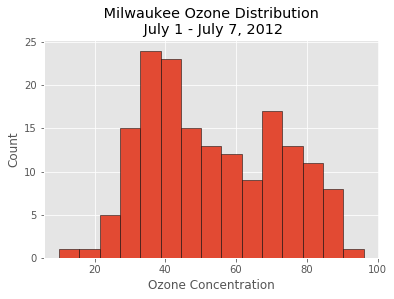

In [11]:
plt.hist(hourly_ozone_july['Sample Measurement']*1000, bins=15, ec='black')
plt.xlabel('Ozone Concentration')
plt.ylabel('Count')
plt.title(' Milwaukee Ozone Distribution \n July 1 - July 7, 2012')
plt.show()

#### A Moment of Zen
Before we jump into a new plot, take a moment to look at the histogram we made and if anything catches your eye. The first thing I notice is that it is not a simple normal distribution but instead it is bimodal in nature. This is where some first order knowledge in tropospheric chemistry will come in useful. What we are see in the left mode is likely ozone concentrations during the evening and night when ozone is commonly the lowest. The right mode is likely ozone observed during the day when freshly emitted NOx and VOCs are undergoing photolyzation and creating 'new' ozone. Now let's make a timeseries to see if our guess is right.

#### Creating A Time Series
Since we had two columns for both date and time, I use a dirty hack to quickly generate a single dataframe column for the week we are analyzing using the date_range function.

Using pyplot's plot function, I use time for our x-axis, and ozone concentration (that we ordered by time a few steps back) for our y-axis. After adding some specifications for style and labels, sure enough, we see during the day ozone often reaches above 60 ppb and during the night drops below 60 ppb. 60 ppb is signigiant here because if we look back at the histogram we'll see that's right where our 2 modal distributions are split.

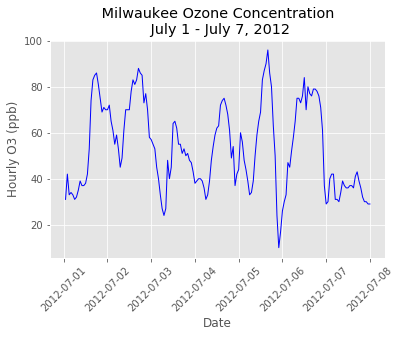

In [12]:
time = pd.date_range('7/1/2012', '7/8/2012', freq='H', closed="right")
plt.plot(time, hourly_ozone_july['Sample Measurement']*1000, color="blue", linewidth=1.0, linestyle="-")
plt.xlabel('Date')
plt.ylabel('Hourly O3 (ppb)')
plt.title(' Milwaukee Ozone Concentration \n July 1 - July 7, 2012')
plt.xticks(rotation=45)
plt.show()